<h1> Importation des bibliotheques necessaires </h1>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

<h1> Ignorer les avertissements </h1>

In [2]:
import warnings
warnings.filterwarnings("ignore")

<h1> Chargement des donnees </h1>

In [3]:
# Charger le dataset
file_path = 'insurance.csv'
data = pd.read_csv(file_path)

# Afficher les premières lignes du dataset
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520



<h3 style='color:green'> Dimension du dataset </h3>

In [4]:
info_df = pd.DataFrame({
    'Nombre de lignes': [data.shape[0]],
    'Nombre de colonnes': [data.shape[1]]
})
info_df

,Nombre de lignes,Nombre de colonnes
0,1338,7


<h3 style='color:green'> Affichage des informations sur les colonnes, les types de données et  quelques informations  </h3>

In [5]:
print("\nInformations sur le dataset :")
print(data.info())



Informations sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


<h3 style='color:green'> Analyse exploratoire des donnees </h3>

In [6]:
print("\nStatistiques descriptives :")
print(data.describe())


Statistiques descriptives :
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


<h1> Nettoyage des donnees </h1>

<h3 style='color:green'> Vérifier les valeurs manquantes

In [7]:
print(data.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


Les résultats montrent qu'il n'y a aucune valeur manquante dans le dataset pour toutes les colonnes (age, sex, bmi, children, smoker, region, charges). Cela signifie que le dataset est complet et prêt pour l'analyse sans avoir à gérer de données manquantes

<h3 style='color:green'> Vérifier s'il y a des doublons dans le dataset

In [8]:
duplicated_rows = data.duplicated().sum()
# Afficher le nombre de doublons
print(f"Nombre de lignes dupliquées : {duplicated_rows}")

Nombre de lignes dupliquées : 1


Le dataset contient 1 ligne dupliquée, ce qui peut introduire du biais dans l'analyse ou les modèles si elle est conservée. Il est recommandé de la supprimer pour garantir l'intégrité des données.

<p style="color:red">Supression des doublons

In [9]:
data = data.drop_duplicates()
# Afficher les premières lignes après suppression des doublons
print(data.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [10]:
duplicated_rows = data.duplicated().sum()
# Afficher le nombre de doublons
print(f"Nombre de lignes dupliquées : {duplicated_rows}")

Nombre de lignes dupliquées : 0


on observe qu'aucune valeur  doublon n'a été détecté maintenant dans l'ensemble des données


<h3 style='color:green'> Vérifier s'il y a des valeurs aberrantes dans le dataset

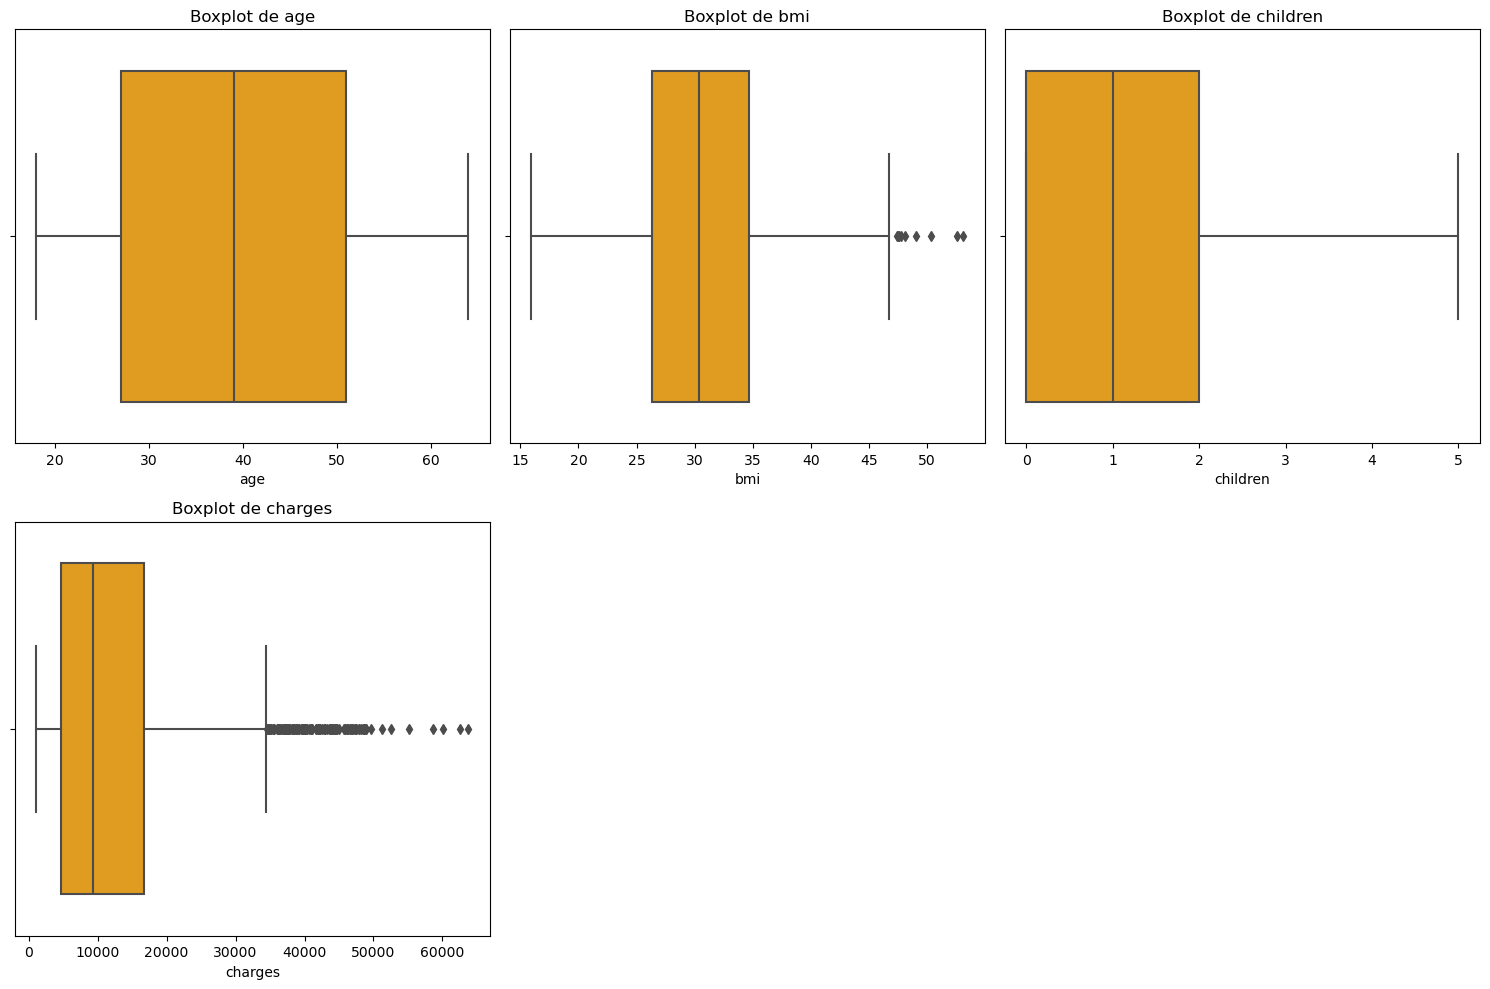

In [11]:
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, start=1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=data[col], color='orange')
    plt.title(f"Boxplot de {col}")
plt.tight_layout()
plt.show()

Concernant age :
Aucune valeur aberrante détectée. Les données d'âge sont bien réparties dans l'intervalle [20, 60].

A propos de  bmi (Body Mass Index) :
Quelques valeurs aberrantes sont présentes du côté supérieur (> 40). Cela représente des individus avec un indice de masse  corporelle particulièrement élevé, ce qui pourrait indiquer des cas d'obésité extrême.

Pour children :
Aucune valeur aberrante détectée. Les données sur le nombre d'enfants se situent dans la plage attendue [0, 5].

Charges (Coût des assurances) :
De nombreuses valeurs aberrantes sont présentes dans les charges élevées (> 30,000). Ces valeurs peuvent représenter des cas exceptionnels, comme des individus nécessitant des soins coûteux (ex. : fumeurs ou maladies graves)

<p style="color:red" >Suppression des valeurs aberrantes (basée sur l'IQR)

In [12]:
for col in numerical_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

print("\nTaille des données après suppression des valeurs aberrantes :", data.shape)


Taille des données après suppression des valeurs aberrantes : (1190, 7)


<h3 style='color:green'> Encodage des variables catégoriques

In [13]:
print("\nTypes de données avant conversion :")
print(data.dtypes)


Types de données avant conversion :
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


Pas idéal pour une modélisation. Les colonnes: sex, smoker et region doivent être encodées.
 (par exemple,pour sex : avec un encodage binaire comme 0 pour female et 1 pour male).


In [14]:
from sklearn.preprocessing import LabelEncoder

# Appliquer LabelEncoder sur chaque colonne catégorielle
encoder = LabelEncoder()

for column in ['sex', 'smoker', 'region']:  # Colonnes catégorielles
    data[column] = encoder.fit_transform(data[column])

# Vérification des types de données après l'encodage
print("\nTypes de données après encodage :")
print(data.dtypes)


Types de données après encodage :
age           int64
sex           int32
bmi         float64
children      int64
smoker        int32
region        int32
charges     float64
dtype: object


<h1> Visualisation des donnees </h1>

<h3 style='color:green'>  Scatter plot pour chaque paire de variables

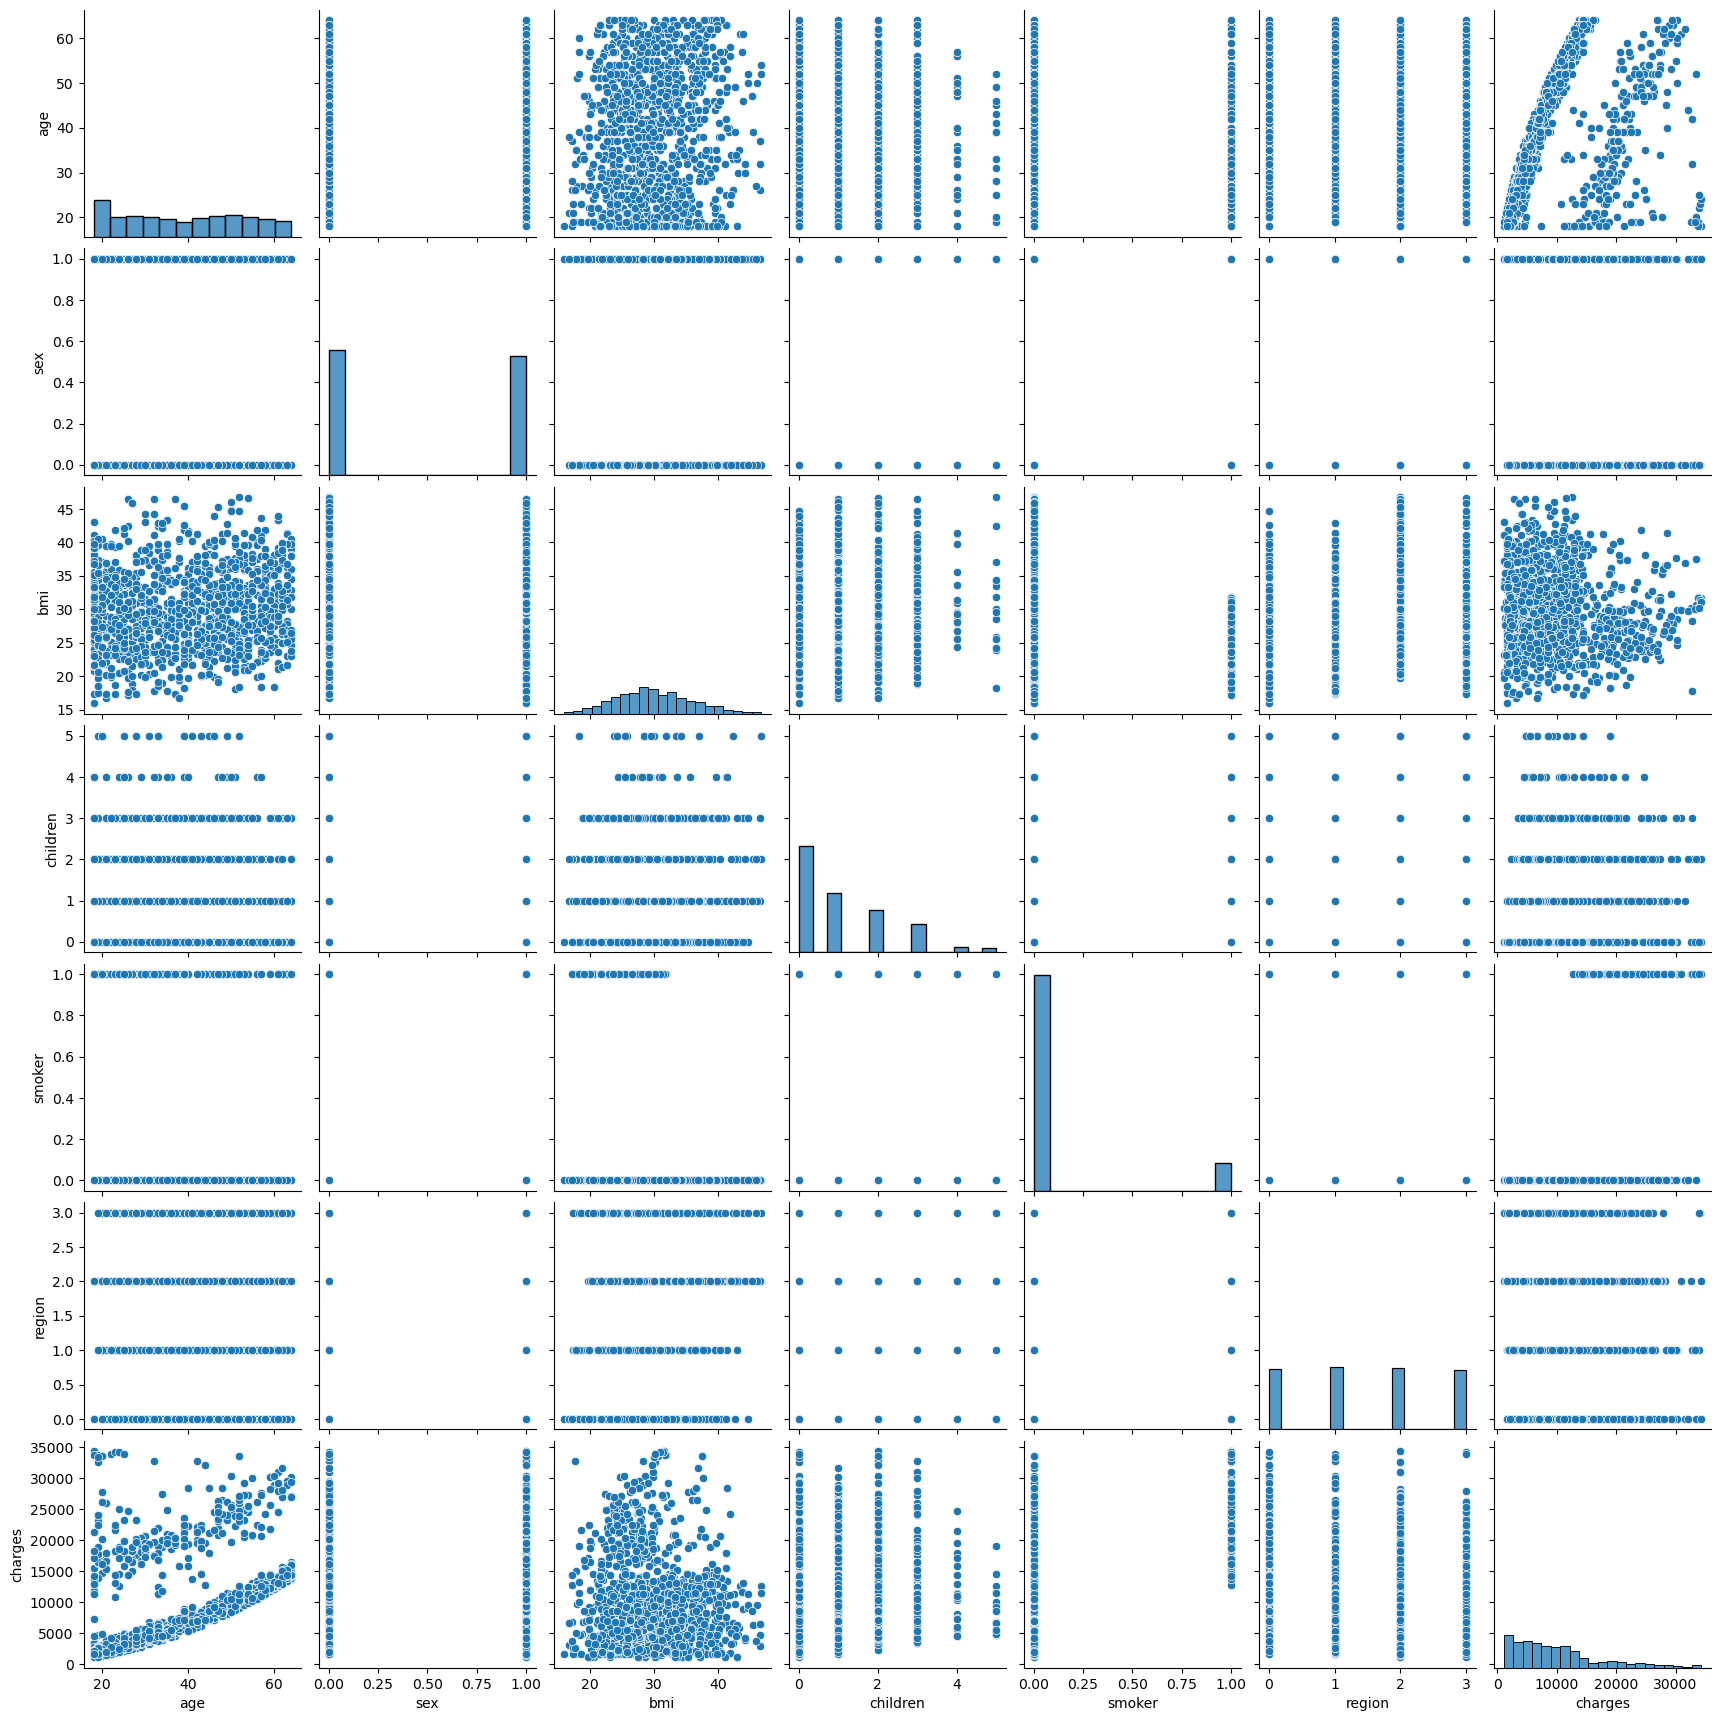

In [15]:
# Créez un scatter plot pour chaque paire de variables
sns.pairplot(data)
plt.show()

Ce graphique montre les relations entre les variables.  
- Les coûts (charges) augmentent avec l’âge, le bmi et surtout si la personne est fumeuse.  
- Les histogrammes montrent la répartition des données, et les points révèlent des tendances ou des regroupements (ex. fumeurs/non-fumeurs).  
C'est utile pour repérer les facteurs qui influencent les coûts.

<h3 style='color:green'> Histogramme pour chaque variable numérique

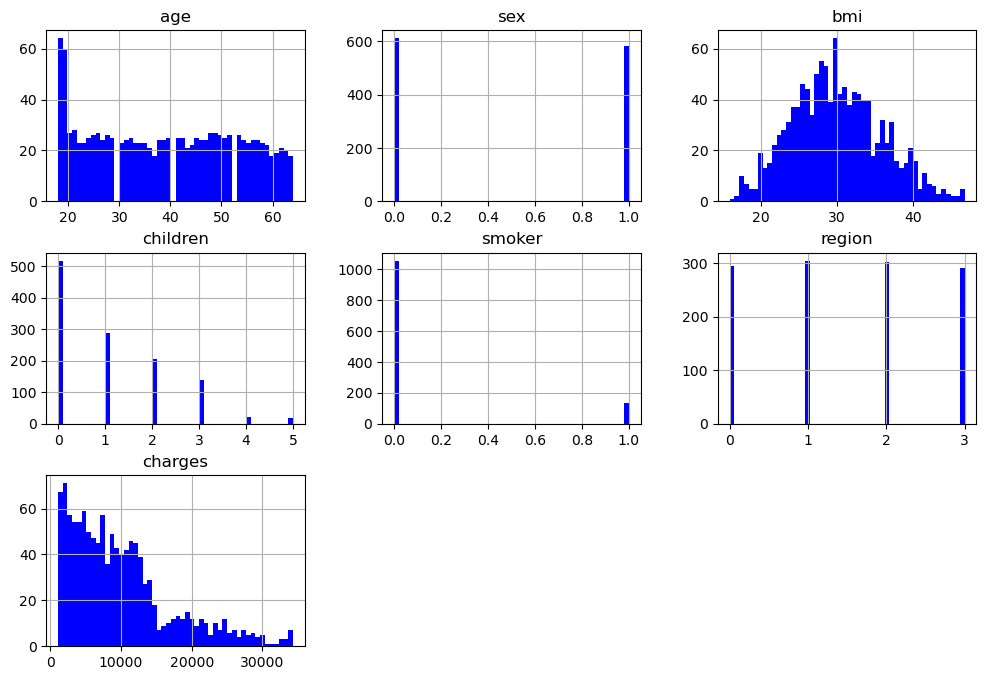

In [16]:
data.hist(bins=50 , figsize=(12,8), color='blue')
plt.show()

La majorité des individus sont âgés de 20 à 60 ans, avec un BMI autour de 30 et 0 à 2 enfants. La plupart sont non-fumeurs, répartis équitablement entre quatre régions, et les coûts médicaux sont généralement inférieurs à 10 000, avec quelques valeurs élevées.

<h3 style='color:green'> Boxplots pour les variables numériques par rapport aux variables catégorielles

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')


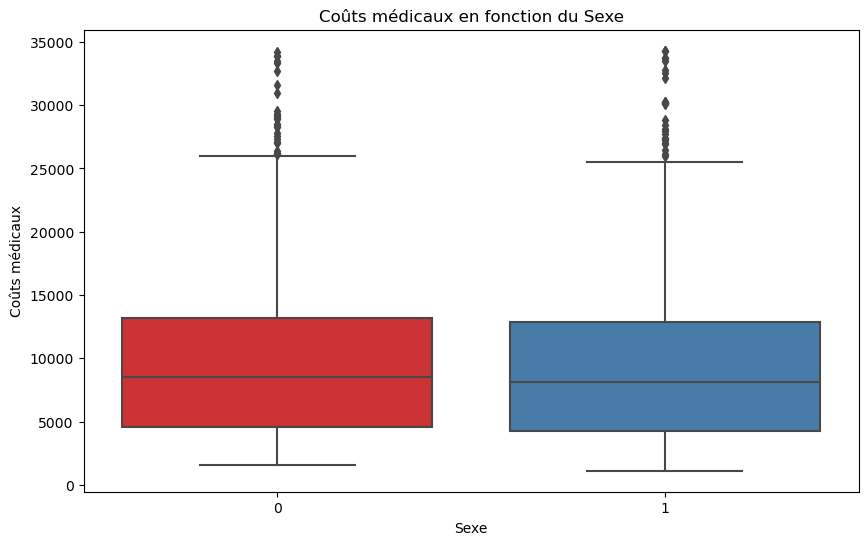

In [17]:
# Vérification des colonnes et conversion en catégorie
print(data.columns)
data['sex'] = data['sex'].astype('category')

# Création du graphique boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='sex', y='charges', data=data, palette='Set1')
plt.title('Coûts médicaux en fonction du Sexe')
plt.xlabel('Sexe')
plt.ylabel('Coûts médicaux')
plt.show()


Ce graphique montre les coûts médicaux en fonction du sexe. Voici l'interprétation :

Sexe 0 (probablement homme) : Les coûts médicaux sont principalement situés entre 5 000 et 15 000, avec quelques valeurs aberrantes qui dépassent les 25 000.
Sexe 1 (probablement femme) : Les coûts médicaux sont similaires, mais légèrement plus élevés en moyenne, avec une plage allant de 5 000 à 20 000 et quelques valeurs extrêmes plus proches de 30 000.
En résumé, bien que les coûts médicaux semblent similaires pour les deux sexes, les femmes semblent avoir des coûts plus élevés en moyenne avec quelques cas extrêmes.

<h3 style='color:green'> Nuages de points (scatter plots) pour les relations entre les variables numériques

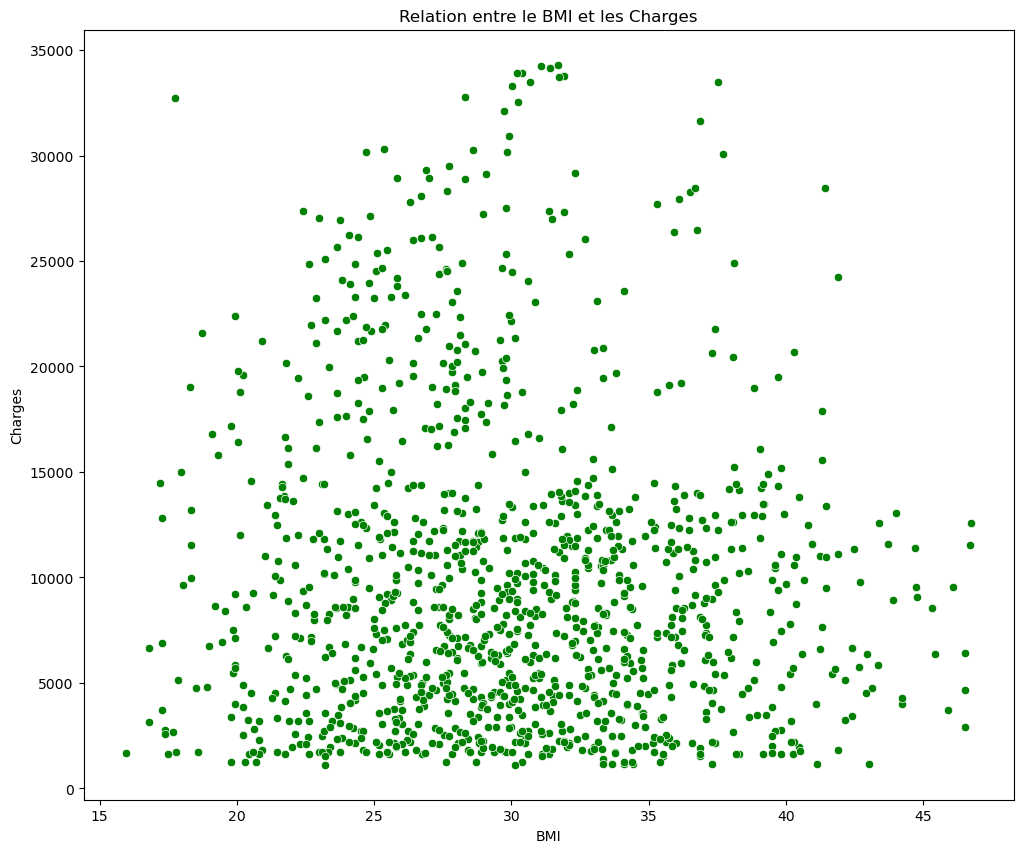

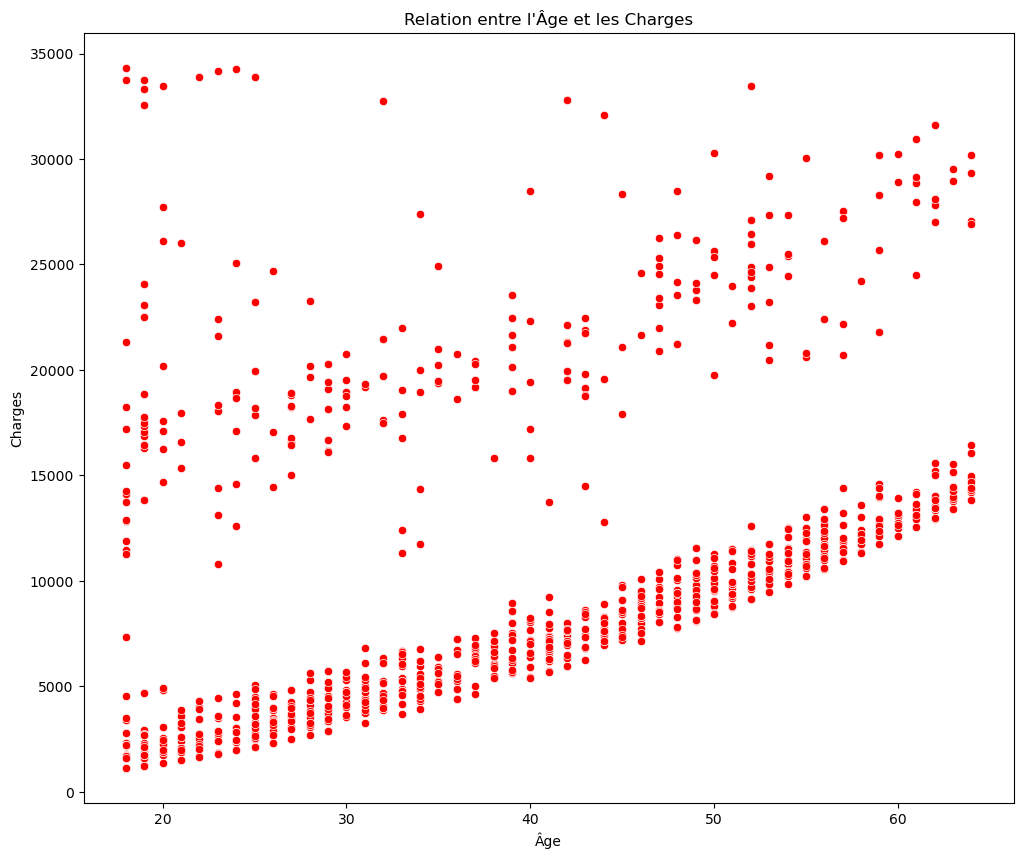

In [18]:
# Nuage de points pour les variables numériques
plt.figure(figsize=(12, 10))
sns.scatterplot(x='bmi', y='charges', data=data, color='green')
plt.title('Relation entre le BMI et les Charges')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.show()

plt.figure(figsize=(12, 10))
sns.scatterplot(x='age', y='charges', data=data, color='red')
plt.title('Relation entre l\'Âge et les Charges')
plt.xlabel('Âge')
plt.ylabel('Charges')
plt.show()


Ce graphique contient deux nuages de points (scatter plots) qui montrent les relations entre certaines variables :

1. *Relation entre le BMI (indice de masse corporelle) et les Charges* (graphique du haut, points verts) :
   - Les charges sont assez dispersées pour différents niveaux de BMI.
   - Il n’y a pas de tendance claire, mais les personnes avec un BMI plus élevé semblent avoir des charges légèrement plus élevées en moyenne.

2. *Relation entre l’Âge et les Charges* (graphique du bas, points rouges) :
   - On observe une tendance : plus l’âge augmente, plus les charges sont élevées.
   - Cela montre une relation positive claire entre l’âge et les coûts.

Ces graphiques illustrent comment ces deux variables influencent les coûts.

<h3 style='color:green'>  la matrice de corrélation

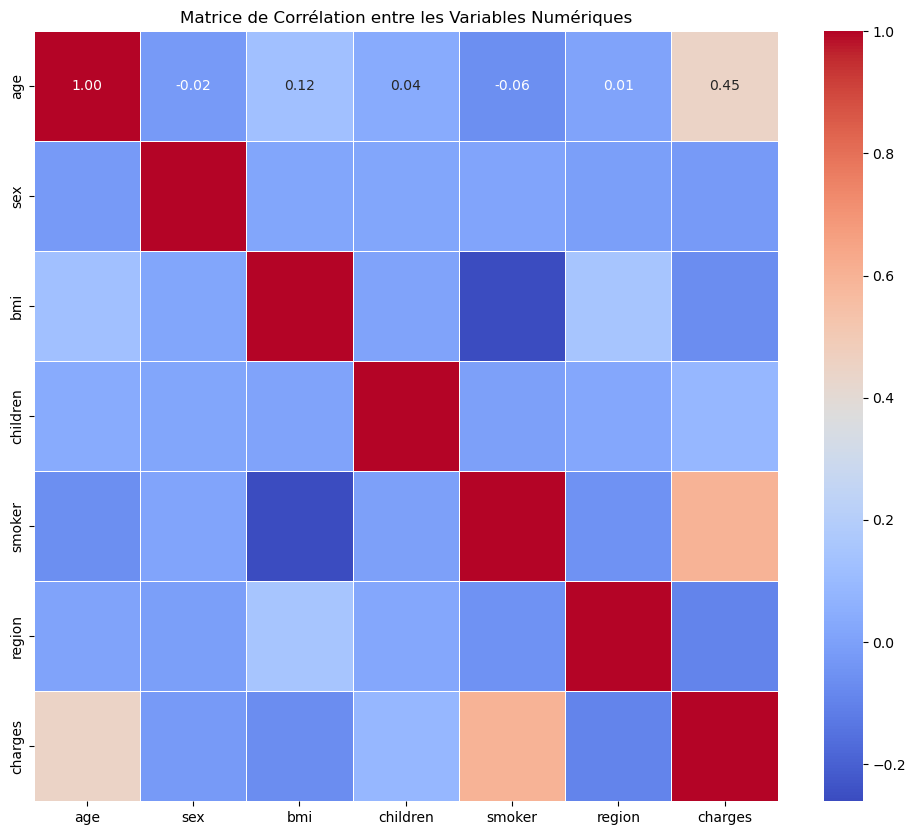

In [19]:
# Matrice de corrélation
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de Corrélation entre les Variables Numériques')
plt.show()


<h3 style='color:green'>  Visualisation des variables catégorielles avec des pourcentages

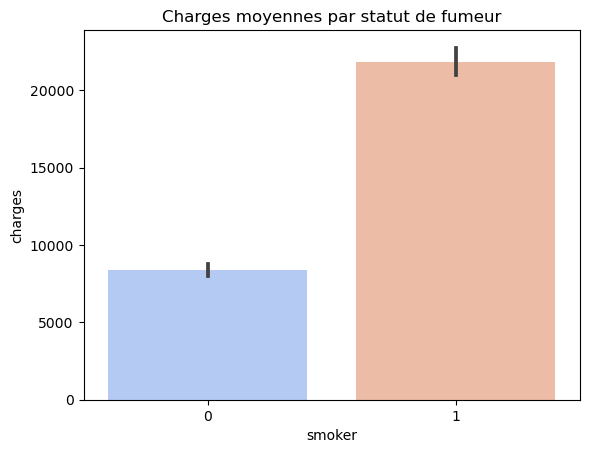

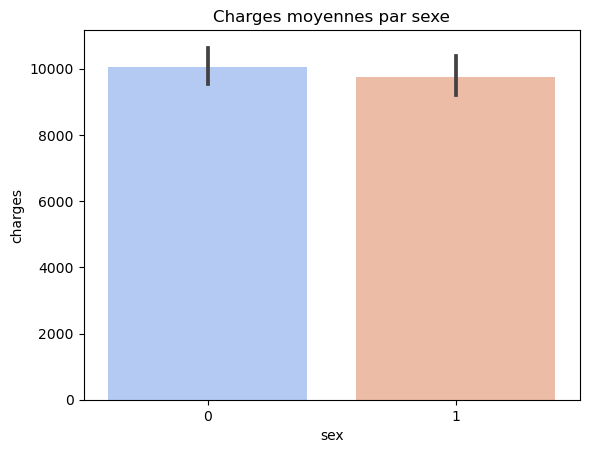

In [20]:
# Pourcentage de fumeurs/non-fumeurs par rapport aux charges
sns.barplot(x='smoker', y='charges', data=data, estimator=np.mean, palette='coolwarm')
plt.title('Charges moyennes par statut de fumeur')
plt.show()

# Pourcentage par sexe
sns.barplot(x='sex', y='charges', data=data, estimator=np.mean, palette='coolwarm')
plt.title('Charges moyennes par sexe')
plt.show()


Fumeurs : Les charges moyennes des fumeurs sont nettement plus élevées que celles des non-fumeurs.
Sexe : Les charges moyennes sont similaires entre les deux sexes, sans différence notable.

Conclusion : Le statut de fumeur influence davantage les charges que le sexe.

 <h3 style='color:green'> Graphiques de tendances

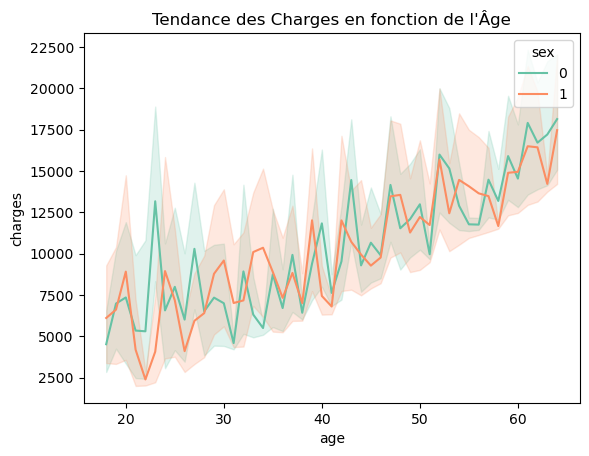

In [21]:
# Relation entre l'âge et les charges
sns.lineplot(x='age', y='charges', data=data, hue='sex', markers=["o", "s"], palette='Set2')
plt.title('Tendance des Charges en fonction de l\'Âge')
plt.show()


Les charges augmentent avec l'âge pour les deux sexes. Les fluctuations sont plus marquées entre 20 et 30 ans, puis se stabilisent après 40 ans. Les hommes et les femmes ont des charges similaires, avec une forte hausse après 60 ans.

<h3 style='color:green'> Diagrammes de densité

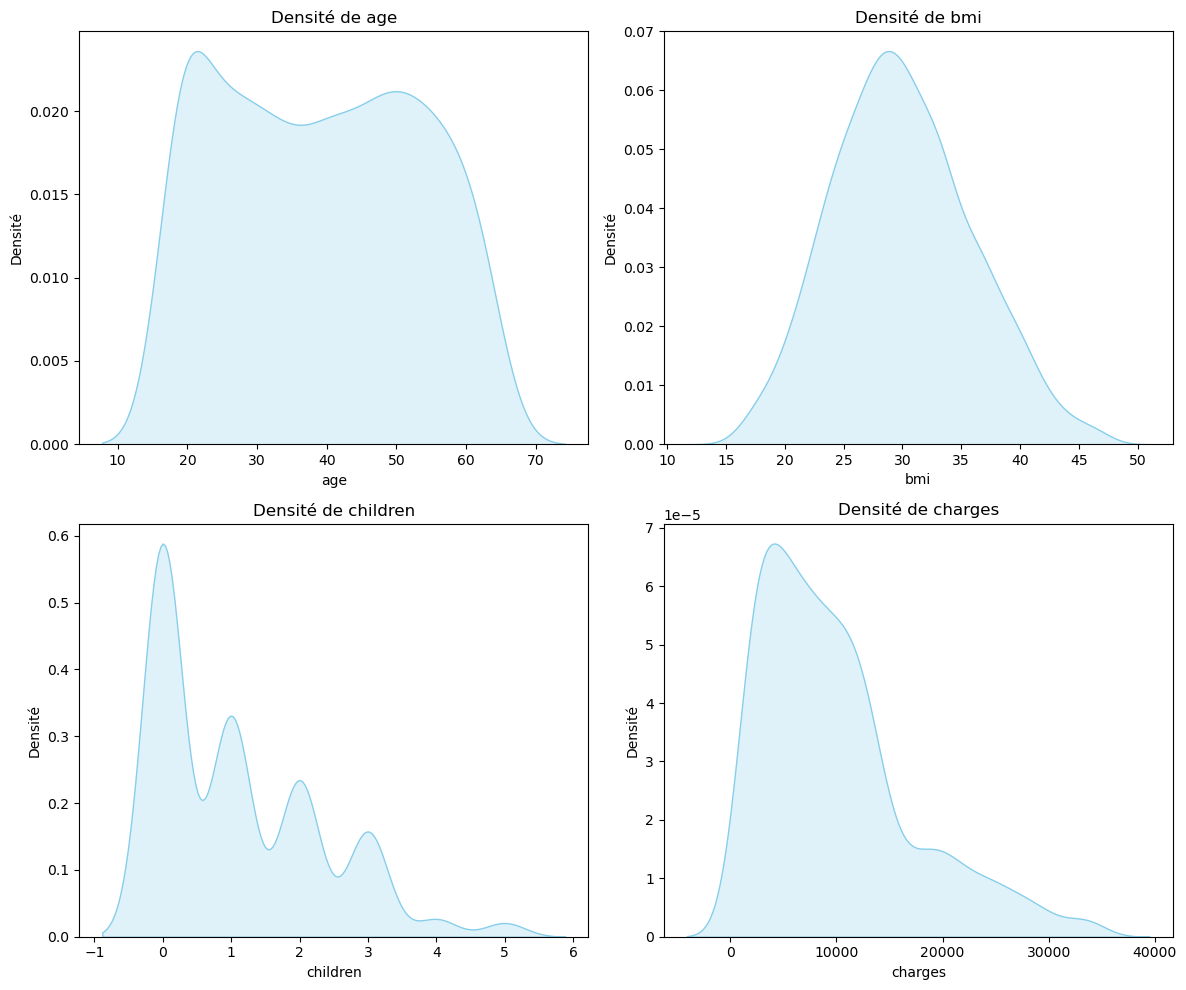

In [22]:
# Diagrammes de densité pour toutes les variables
plt.figure(figsize=(12, 10))

# Liste des variables numériques pour les diagrammes de densité
numerical_columns = ['age', 'bmi', 'children', 'charges']

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    sns.kdeplot(data[col], shade=True, color='skyblue')
    plt.title(f'Densité de {col}')
    plt.xlabel(col)
    plt.ylabel('Densité')

plt.tight_layout()
plt.show()


- *Âge* : Distribution bimodale, avec des pics autour de 20 et 55 ans.  
- *BMI* : Distribution symétrique, centrée autour de 30, proche d'une courbe normale.  
- *Enfants* : La plupart des individus ont entre 0 et 2 enfants, avec une diminution progressive pour des nombres plus élevés.  
- *Charges* : Distribution asymétrique, avec la majorité des charges concentrées en dessous de 15 000, et quelques valeurs extrêmes élevées.  

*Conclusion* : L'âge et les charges montrent des distributions spécifiques (bimodalité et asymétrie), tandis que le BMI et le nombre d'enfants sont plus uniformément répartis.

<h1> Regression sur chaque variable

In [23]:
from scipy.stats import f
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.anova import anova_lm
def lm(x):
    data['const'] = 1  # Ajouter une constante pour le modèle
    # Définir la variable dépendante et les variables indépendantes
    Y = data['charges']  # Variable cible
    X = data[['const', x]]  # Variable explicative + constante
    # Ajuster le modèle linéaire
    lm_model = sm.OLS(Y, X).fit()
    # Afficher les résultats du modèle
    print(f"Modèle pour la variable indépendante : {x}")
    print(lm_model.summary())
    
    # Calculer et afficher le QQ plot des résidus
    residuals = lm_model.resid
    qqplot(residuals, line='s', color='blue')
    plt.title(f"QQ Plot des résidus pour la variable : {x}")
    plt.show()
    
    # Calcul des métriques du modèle
    R2_model = lm_model.rsquared
    R2_adj_model = lm_model.rsquared_adj
    Fcalc_model = lm_model.fvalue
    
    n = data.shape[0]  # Nombre d'observations
    p = 1  # Nombre de prédicteurs (excluant la constante)
    Ftbl_model = f.isf(0.05, p, n - (p + 1))  # Valeur critique de F
    
    # Retourner les métriques dans un DataFrame
    return pd.DataFrame(
        [R2_model * 100, R2_adj_model * 100, Fcalc_model, Ftbl_model],
        index=['R2', 'R2_adj', 'Fcalc', 'Ftbl_model'],
        columns=[x]
    )

<h3 style='color:green'>Regression sur 'age'

Modèle pour la variable indépendante : age
                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     298.4
Date:                Fri, 24 Jan 2025   Prob (F-statistic):           8.03e-60
Time:                        16:32:22   Log-Likelihood:                -12122.
No. Observations:                1190   AIC:                         2.425e+04
Df Residuals:                    1188   BIC:                         2.426e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

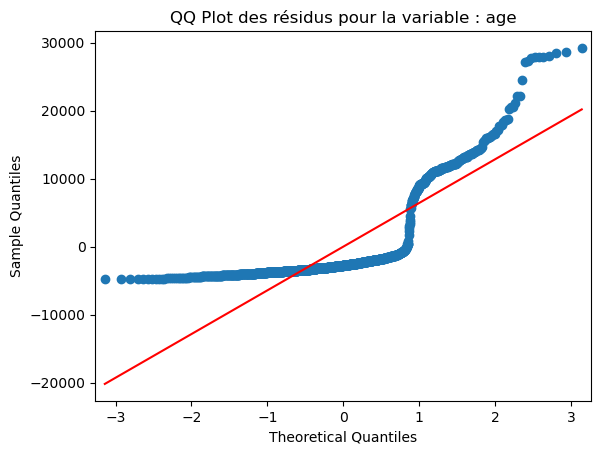

                   age
R2           20.075088
R2_adj       20.007811
Fcalc       298.395122
Ftbl_model    3.849298


In [24]:
result = lm('age')
print(result)

On a Fcalc >>> Ftbl_model danc on rejette au niveau de risque 5% l'hypothèse H0 d'ou le modèle est globalement significatif

<h3 style='color:green'>Regression sur 'bmi'

Modèle pour la variable indépendante : bmi
                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.951
Date:                Fri, 24 Jan 2025   Prob (F-statistic):             0.0263
Time:                        16:32:23   Log-Likelihood:                -12253.
No. Observations:                1190   AIC:                         2.451e+04
Df Residuals:                    1188   BIC:                         2.452e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

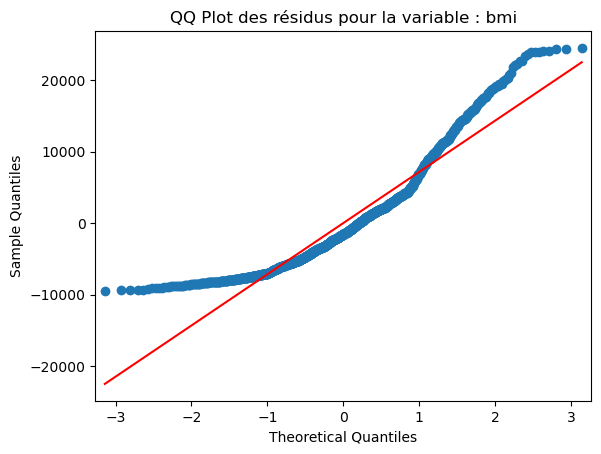

                 bmi
R2          0.415001
R2_adj      0.331175
Fcalc       4.950753
Ftbl_model  3.849298


In [25]:
result = lm('bmi')
print(result)

On a Fcalc > Ftbl_model danc on rejette au niveau de risque 5% l'hypothèse H0 d'ou le modèle est globalement significatif

<h3 style='color:green'>Regression sur 'children'

Modèle pour la variable indépendante : children
                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     9.335
Date:                Fri, 24 Jan 2025   Prob (F-statistic):            0.00230
Time:                        16:32:23   Log-Likelihood:                -12251.
No. Observations:                1190   AIC:                         2.451e+04
Df Residuals:                    1188   BIC:                         2.452e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

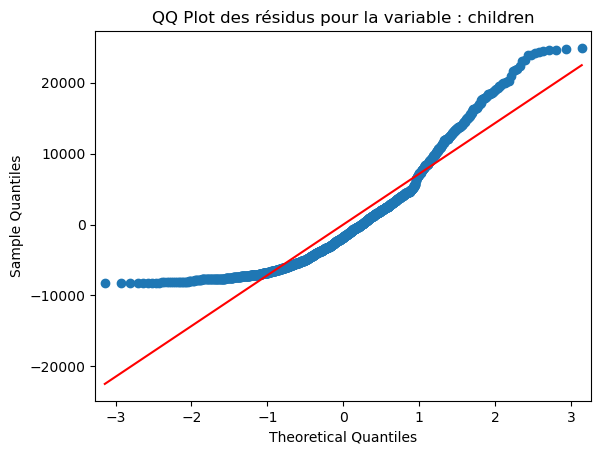

            children
R2          0.779642
R2_adj      0.696123
Fcalc       9.334929
Ftbl_model  3.849298


In [26]:
result = lm('children')
print(result)

On a Fcalc > Ftbl_model danc on rejette au niveau de risque 5% l'hypothèse H0 d'ou le modèle est globalement significatif

<h3 style='color:green'>Regression sur 'sexe'

Modèle pour la variable indépendante : sex
                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5713
Date:                Fri, 24 Jan 2025   Prob (F-statistic):              0.450
Time:                        16:32:23   Log-Likelihood:                -12255.
No. Observations:                1190   AIC:                         2.451e+04
Df Residuals:                    1188   BIC:                         2.452e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

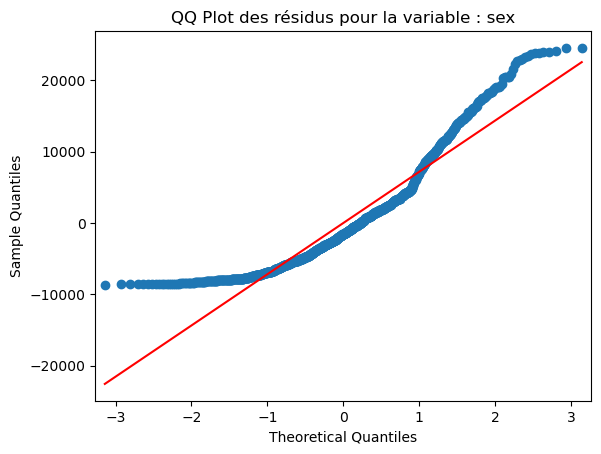

                 sex
R2          0.048069
R2_adj     -0.036066
Fcalc       0.571333
Ftbl_model  3.849298


In [27]:
result = lm('sex')
print(result)

On a Fcalc < Ftbl_model danc on accepte au niveau de risque 5% l'hypothèse H0 d'ou le modèle n'est pas significatif

<h3 style='color:green'>Regression sur 'smoker'

Modèle pour la variable indépendante : smoker
                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     655.3
Date:                Fri, 24 Jan 2025   Prob (F-statistic):          1.87e-115
Time:                        16:32:24   Log-Likelihood:                -11994.
No. Observations:                1190   AIC:                         2.399e+04
Df Residuals:                    1188   BIC:                         2.400e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

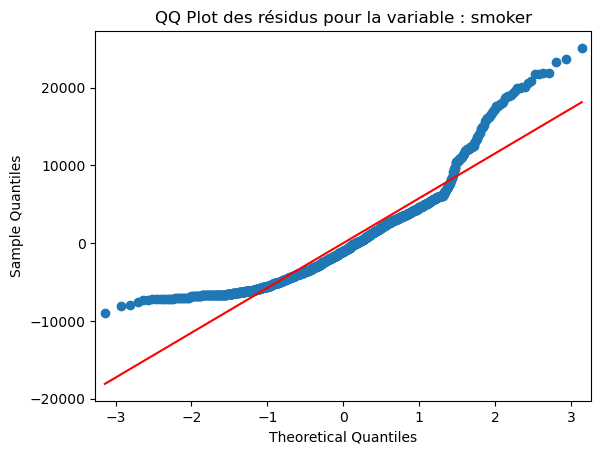

                smoker
R2           35.549015
R2_adj       35.494763
Fcalc       655.261201
Ftbl_model    3.849298


In [28]:
result = lm('smoker')
print(result)

On a Fcalc >>> Ftbl_model danc on rejette au niveau de risque 5% l'hypothèse H0 d'ou le modèle est globalement significatif

<h3 style='color:green'>Regression sur 'region'

Modèle pour la variable indépendante : region
                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     11.29
Date:                Fri, 24 Jan 2025   Prob (F-statistic):           0.000804
Time:                        16:32:24   Log-Likelihood:                -12250.
No. Observations:                1190   AIC:                         2.450e+04
Df Residuals:                    1188   BIC:                         2.451e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

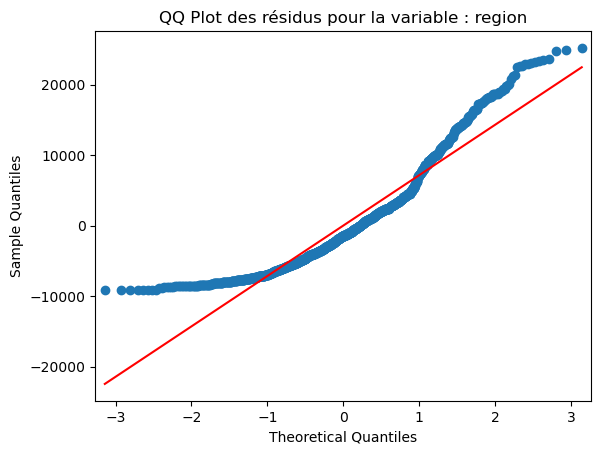

               region
R2           0.941419
R2_adj       0.858036
Fcalc       11.290346
Ftbl_model   3.849298


In [29]:
result = lm('region')
print(result)


On a Fcalc > Ftbl_model danc on rejette au niveau de risque 5% l'hypothèse H0 d'ou le modèle est globalement significatif

<h1> Preparation des donnees pour la regression 

In [30]:
X = data.drop(columns=["const","charges"])  # Supposons que 'charges' est la cible
y = data['charges']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)


<h1>Regression sur toutes les variables

<h3 style='color:green'> Entrainement de model


In [32]:
def lm1(X,y):
    return sm.OLS(y, sm.add_constant(X)).fit()


In [33]:
model=lm1(X,y)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     302.0
Date:                Fri, 24 Jan 2025   Prob (F-statistic):          1.61e-234
Time:                        16:32:25   Log-Likelihood:                -11703.
No. Observations:                1190   AIC:                         2.342e+04
Df Residuals:                    1183   BIC:                         2.345e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2821.3093    797.047     -3.540      0.000   -4385.094   -1257.525
age          244.7155      9.433     25.942      0.000     226.208     263.223
sex         -344.8110    262.809     -1.312      0.190    -860.435     170.813
bmi           65.6794     23.561      2.788      0.005      19.454     111.905
children     435.4374    108.064      4.029      0.000     223.419     647.456
smoker      1.437e+04    427.670     33.611      0.000    1.35e+04    1.52e+04
region      -495.7514    119.664     -4.143      0.000    -730.528    -260.975
==============================================================================
Omnibus:                      754.845   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5443.653
Skew:                           3.044   Prob(JB):                         0.00
Kurtosis:                      11.528   Cond. No.                         314.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Le modèle de régression montre que certaines variables, comme l'âge, l'IMC, le statut de fumeur et le nombre d'enfants, ont un impact significatif sur les charges, avec des coefficients qui indiquent des variations importantes des charges selon ces facteurs. En revanche, d'autres variables comme le sexe ne sont pas statistiquement significatives. Le modèle explique environ 60% de la variation des charges (R-squared = 0.605), mais il y a des indications que les résidus ne suivent pas une distribution normale, ce qui pourrait affecter la validité des résultats.

<h3 style='color:green'> Prediction des valeurs


In [34]:
#Fonction de prediction
def predire(x):
    x1=[1]+list(x)
    return np.sum(model.params*x1)   

In [35]:
def predire_indice(i):
    print(pd.DataFrame([predire(X.iloc[i,:]),y.iloc[i]], index=['Valeur prédite','Valeur réelle'],columns=['Exemple'+str(1+i)]))

In [36]:
#la prédiction du premier exemple
predire_indice(0)

                    Exemple1
Valeur prédite  16548.070227
Valeur réelle   16884.924000


In [37]:
#la predictinon des 5 premières valeurs
for i in range(5):
    predire_indice(i)

                    Exemple1
Valeur prédite  16548.070227
Valeur réelle   16884.924000
                  Exemple2
Valeur prédite  2900.68838
Valeur réelle   1725.55230
                   Exemple3
Valeur prédite  6168.145307
Valeur réelle   4449.462000
                    Exemple4
Valeur prédite   5904.992534
Valeur réelle   21984.470610
                   Exemple5
Valeur prédite  6065.847511
Valeur réelle   3866.855200


In [38]:
R2_model = model.rsquared
R2_adj_model = model.rsquared_adj
Fcalc_model = model.fvalue

In [39]:
pd.DataFrame([R2_model*100,R2_adj_model*100,Fcalc_model], index=['R2','R2_adj','Fcalc'],columns=['Model'])

,Model
R2,60.498361
R2_adj,60.298015
Fcalc,301.968744


Conclusion: Le modèle présente une bonne qualité prédictive avec un R² de 60,50%, indiquant qu’il explique 60,50% de la variabilité des données. Légèrement ajusté à 60,30%, cela montre qu’il reste pertinent sans sur-ajustement. De plus, la F-statistique élevée (301,97) confirme la significativité globale du modèle, prouvant que les variables explicatives ont un impact notable sur les résultats. Cela reflète un modèle fiable et statistiquement solide.

<h3 style='color:green'> Tests d'hypothese


<strong style="color:red">Test de Student 

In [40]:
from scipy.stats import t
# degrés de liberté
n = data.shape[0]
p = 0.95
# calcul de la valeur de la table de student
value = t.ppf(p, n)
print("La valeur de la table de student pour n =", n, "et p =", p, "est", value)

La valeur de la table de student pour n = 1190 et p = 0.95 est 1.6461351087076712


In [41]:
pd.DataFrame({'|tvalue|': np.abs(model.tvalues.tolist()), 'ttabl': [value] * len(model.tvalues)}, index=model.params.index)

,|tvalue|,ttabl
const,3.539701,1.646135
age,25.941590,1.646135
sex,1.312021,1.646135
bmi,2.787664,1.646135
children,4.029443,1.646135
smoker,33.611367,1.646135
region,4.142878,1.646135


Avec |tcal| > ttbl pourm5%. Par conséquent 
Les coefficients sont tous significatifs

<strong style="color:red">Test de Fisher 



Calcul de la valeur de la table de Fisher pour un niveau de confiance de 95% et un degré de liberté numérateur (dfn) de p et un degré de liberté dénominateur (dfd) de n-(p+1)</li>    


In [42]:
n = data.shape[0]
p = data.shape[1]
Ftbl_model = f.isf(0.05, p, n-(p+1))

In [43]:
pd.DataFrame([Ftbl_model,model.fvalue], index=['Ftbl','fcal'],columns=['Model'])

,Model
Ftbl,1.946229
fcal,301.968744


Les variables âge, nombre d'enfants, fumeur et région sont significatives, tandis que sexe n’a pas d’effet notable, selon les t-values comparées à la valeur critique.

<h3 style='color:green'>Intervalles de confiance


In [44]:
# Obtenir les intervalle de confiance des paramètres du modèle
alpha = 0.05 # 95% confidence interval
conf_interval = model.conf_int(alpha)

In [45]:
index = ['Intercept']+[col+" Coef." for col in X.columns]
conf_interval.index = index
conf_interval.columns = ["min","Max"]
conf_interval

,min,Max
Intercept,-4385.093549,-1257.525088
age Coef.,226.207617,263.223456
sex Coef.,-860.435006,170.813006
bmi Coef.,19.453942,111.904929
children Coef.,223.419090,647.455639
smoker Coef.,13535.505584,15213.659186
region Coef.,-730.527830,-260.975019


Les intervalles de confiance à 95 % pour les coefficients du modèle montrent que les coefficients montrent que l'âge, le BMI, le nombre d'enfants, et le statut de fumeur ont des effets significatifs, avec le fumeur ayant le plus grand impact. Le sexe a un effet moins stable, tandis que la région a un effet négatif.

<h3 style='color:green'>Analyse des residus


In [46]:
residuals = model.resid

<strong style="color:red">Plot de la régression des résidus

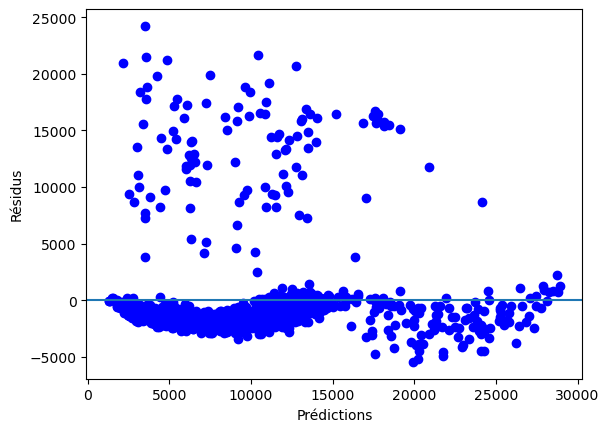

In [47]:
plt.scatter(model.predict(), residuals,color="blue")
plt.xlabel("Prédictions")
plt.ylabel("Résidus")
plt.axhline(y=0)
plt.show()


Ce graphique montre les résidus en fonction des prédictions. On observe une structure non aléatoire, avec une courbure en U, ce qui suggère que le modèle ne capture pas bien les relations dans les données. Cela indique un problème potentiel de spécification du modèle

<h1>Analyse de la Variance (ANOVA)


In [48]:
# Créer le modèle OLS en utilisant une formule
formula = 'y ~ ' + ' + '.join(X.columns)
model_ols = sm.OLS.from_formula(formula, data=pd.concat([X, y], axis=1))

# Ajuster le modèle en utilisant la méthode fit
model_fit = model_ols.fit()

# Obtenir la table ANOVA
anova_table = pd.DataFrame(anova_lm(model_fit))
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
sex,1.0,2.951682e+07,2.951682e+07,1.439574,2.304486e-01
age,1.0,1.230779e+10,1.230779e+10,600.266827,1.503452e-107
bmi,1.0,8.948001e+08,8.948001e+08,43.640564,5.950133e-11
children,1.0,3.206211e+08,3.206211e+08,15.637108,8.128765e-05
smoker,1.0,2.324451e+10,2.324451e+10,1133.664952,7.482390e-175
region,1.0,3.519168e+08,3.519168e+08,17.163440,3.673709e-05
Residual,1183.0,2.425607e+10,2.050386e+07,NaN,NaN


Les résultats de l'analyse de variance (ANOVA) montrent que l'âge, l'IMC, le nombre d'enfants, le statut de fumeur, et la région ont des effets significatifs sur le modèle, avec des valeurs de p très faibles (bien inférieures à 0,05), ce qui confirme leur importance. En revanche, le sexe n'a pas un effet significatif (p-value de 0,23), ce qui suggère qu'il n'a pas une influence notable sur le modèle.

<h1>Modele from Scratch <br> Avec L'Equation normale</h4>

L'équation normale est une expression mathématique et non pas un algorithme itératif, qui permet de résoudre notre problème de régression linéaire en trouvant les valeurs des paramètres pour lesquelles notre fonction MSE est minimisée.
L'équation normale est définie comme ceci : θ=(x⊺x)-1x⊺y
Si la matrice résultant du calcul de x⊺x est non inversible l'équation normale est définie comme ceci : θ=(x⊺x + λ*I)-1x⊺y avec λ > 0

In [49]:
import numpy as np

class LinearRegressionMultipleNormale:
    
    def _init_(self):
        # Initialisation des variables
        self.y_pred = None  # Prédictions
        self.error = None  # Erreurs (y - y_pred)
        self.SCE = None  # Somme des carrés des erreurs
        self.SCT = None  # Somme totale des carrés
        self.SCReg = None  # Somme des carrés de la régression
        self.R_2 = None  # R² (coefficient de détermination)
        self.R_adj = None  # R² ajusté
        self.beta = None  # Coefficients du modèle (incluant l'intercept)
        self.Fcalc = None  # Statistique F

    # Entraînement du modèle en utilisant l'équation normale
    # La régularisation peut être appliquée en définissant lambda > 0 pour éviter les matrices non inversibles
    def train(self, X, y, lambda_=0):
        """
        Entraîne le modèle de régression linéaire.
        
        Args:
            X (ndarray): La matrice des caractéristiques (N échantillons x P caractéristiques).
            y (ndarray): Le vecteur cible (N échantillons).
            lambda_ (float): Paramètre de régularisation (par défaut: 0, pas de régularisation).
        """
        N, P = X.shape
        identity_matrix = np.eye(P + 1)  # Matrice identité pour la régularisation
        identity_matrix[0, 0] = 0  # Ne pas régulariser le terme d'interception
        
        X = np.c_[np.ones(N), X]  # Ajouter le terme d'interception à X
        self.beta = np.linalg.inv(X.T @ X + lambda_ * identity_matrix) @ X.T @ y

    def predict(self, X):
        """
        Fait des prédictions en utilisant le modèle entraîné.
        
        Args:
            X (ndarray): La matrice des caractéristiques (N échantillons x P caractéristiques).
        
        Returns:
            ndarray: Valeurs prédites (N échantillons).
        """
        if self.beta is None:
            raise ValueError("Le modèle n'est pas entraîné. Appelez train() avant predict().")
        
        N = X.shape[0]
        X = np.c_[np.ones(N), X]  # Ajouter le terme d'interception à X
        self.y_pred = X @ self.beta  # Calculer les prédictions
        
        return self.y_pred

    def evaluate(self, y):
        """
        Évalue le modèle en utilisant R², R² ajusté et la statistique F.
        
        Args:
            y (ndarray): Les valeurs cibles réelles (N échantillons).
        
        Returns:
            tuple: R², R² ajusté, et la statistique F.
        """
        if self.y_pred is None:
            raise ValueError("Les prédictions ne sont pas disponibles. Appelez predict() avant evaluate().")
        
        self.error = y - self.y_pred  # Calcul des erreurs
        self.SCE = np.sum(self.error**2)  # Somme des carrés des erreurs
        self.SCT = np.sum((y - y.mean())**2)  # Somme totale des carrés
        self.SCReg = self.SCT - self.SCE  # Somme des carrés expliquée
        
        N = len(y)  # Nombre d'échantillons
        P = len(self.beta) - 1  # Nombre de prédicteurs (sans le terme d'interception)
        
        self.R_2 = 1 - (self.SCE / self.SCT)  # Coefficient de détermination (R²)
        self.R_adj = 1 - (1 - self.R_2) * ((N - 1) / (N - P - 1))  # R² ajusté
        self.Fcalc = (self.SCReg / P) / (self.SCE / (N - P - 1))  # Statistique F
        
        return self.R_2 * 100, self.R_adj * 100, self.Fcalc

In [50]:
# Initialiser le modèle
model_nrml = LinearRegressionMultipleNormale()

# Entraîner le modèle
model_nrml.train(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_test = model_nrml.predict(X_test)

# Évaluer le modèle
R2_nrml, R2_adj_nrml, Fcalc_nrml = model_nrml.evaluate(y_test)

print("R²:", R2_nrml)
print("R² ajusté:", R2_adj_nrml)
print("F-statistique:", Fcalc_nrml)

R²: 58.20811196716641
R² ajusté: 57.122608381898
F-statistique: 53.6231411458431


Notre modèle démontre une capacité prédictive acceptable mais laisse une marge d'amélioration, expliquant 58% de la variance de la variable cible. De plus, la statistique F élevée confirme la significativité globale du modèle, renforcée par le rejet de l'hypothèse nulle à un niveau de risque de 5%.

<h3 style='color:green'>Tests d'hypothese global du modele


In [51]:
Ftbl_nrml = f.isf(0.05, p, n-(p+1))

In [52]:
pd.DataFrame([Ftbl_nrml,Fcalc_nrml], index=['Ftbl','Fcalc'],columns=['Model_normale'])

,Model_normale
Ftbl,1.946229
Fcalc,53.623141


On a Fcal >> Ftbl danc on rejette au niveau de risque 5% l'hypothèse H0 d'où: le modèle est globalement significatif

<h1>Comparaison des modèles</h1>

In [53]:
comp = {'model_statsmodels': [R2_model*100,R2_adj_model*100], 'model_normale': [R2_nrml,R2_adj_nrml]}

In [54]:
pd.DataFrame(comp,index=['R2','R2_adj'])

,model_statsmodels,model_normale
R2,60.498361,58.208112
R2_adj,60.298015,57.122608


Les résultats montrent que le modèle construit avec statsmodels explique mieux la variance des données ( R2 = 60.50%) comparé au modèle construit From scratch  ( R2 = 58.21%). De même, le R2 ajusté est légèrement plus élevé pour le modèle statsmodels  (60.30%) que pour le modèle From scratch (57.12%). Cela indique que le modèle statsmodels est non seulement plus précis, mais aussi potentiellement mieux optimisé en tenant compte de la complexité du modèle.

<h1>Problème de Colinéarité </h1>

In [55]:
X.corr().style.background_gradient()

,age,sex,bmi,children,smoker,region
age,1.000000,-0.020240,0.124055,0.037153,-0.062581,0.005806
sex,-0.020240,1.000000,0.016407,0.016346,0.014343,-0.006985
bmi,0.124055,0.016407,1.000000,0.007625,-0.260642,0.152397
children,0.037153,0.016346,0.007625,1.000000,-0.002172,0.023830
smoker,-0.062581,0.014343,-0.260642,-0.002172,1.000000,-0.052259
region,0.005806,-0.006985,0.152397,0.023830,-0.052259,1.000000


La matrice montre que les variables sont globalement faiblement corrélées, avec une légère corrélation négative entre BMI et Smoker (-0.26) et une faible corrélation positive entre BMI et Region (0.15). Cela indique une faible relation linéaire entre les variables, ce qui est favorable pour des modèles de régression.